For the full project, visit the [GitHub repository](https://github.com/TugdualKerjan/HiFiGAN-for-JAX).

# Context 👀

We are going to implement the HiFiGAN used in [@casanova2024xttsmassivelymultilingualzeroshot], a Text to Speech model written by the defunct Coqai company. The HiFiGAN model was first proposed in [@kong2020hifigangenerativeadversarialnetworks]. The role of this model is to take Mel Spectrograms that represent a sequence of speech and transform them into a wav that we can listen to. This is what comes at the end of the XTTS model that will generate the spectrograms feeding the model. HiFiGaN is composed of a generator and two discriminators.

__Generator__

This part of the model takes in the Mel-Spectrogram and iteratively convolves the input into the desired output shape, here a $[1 \times N]$ tensor representing the time-series (a list of points) giving the amplitude of the sound. Passing this with a sampling rate to audio programs would allow us to listen to it !

__Discriminators__

Since we want the output to be as real as possible, we can use _other_ models to learn to learn to discern the output of our generator from other real inputs. Basically, if this model can't see the difference between real or fake audio then either our generator is doing a good job or the discriminator is doing a bad one !

Here the paper proposes two: One that looks at spaced out points to find patterns that could help discern real from fake, and one that looks at different scales. We can think of this second one as an inspector looking at a modified image for artifacts in hair, or on a bigger scale how the eyes are placed relative to the face. _Anyways_.

![What we hope happens](assets/dis.png)

# Goal 🎯

Get intelligable speech coming out of the HiFiGAN with reasonable (1h tops) amount of training on a NVIDIA L40.

# Model

We have 3 models to code: Generator, MultiPeriod Discriminator and the MultiScaleDiscriminator.

Importing JAX and Equinox, a library that helps with writing neural networks.

In [3]:
import equinox as eqx
import equinox.nn as nn
import jax
import jax.numpy as jnp


## ResBlocks

Two types of ResBlocks are proposed in the HiFiGAN paper, but only one is implemented in XTTS, as we can see below:

![ResBlocks later used in the generator [@kong2020hifigangenerativeadversarialnetworks]](assets/resblocks.png)

We implement them below following XTTS's code.

In [ ]:
LRELU_SLOPE = 0.1


class ResBlock(eqx.Module):
    conv_dil: list
    conv_straight: list
    norm = nn.WeightNorm

    def __init__(
        self,
        channels: int,
        kernel_size: int = 3,
        dilation: int = 1,
        key=None,
    ):
        if key is None:
            raise ValueError("The 'key' parameter cannot be None.")
        self.conv_dil = [
            nn.Conv1d(
                channels,
                channels,
                kernel_size=kernel_size,
                stride=1,
                dilation=dilation,
                padding="SAME",
                key=y,
            )
            for y in jax.random.split(key, 3)
        ]
        self.conv_straight = [
            nn.Conv1d(
                channels,
                channels,
                kernel_size=kernel_size,
                stride=1,
                dilation=1,
                padding="SAME",
                key=y,
            )
            for y in jax.random.split(key, 3)
        ]

    def __call__(self, x):
        for c1, c2 in zip(self.conv_dil, self.conv_straight, strict=False):
            y = jax.nn.leaky_relu(x, LRELU_SLOPE)
            y = self.norm(c1)(y)
            y = jax.nn.leaky_relu(y, LRELU_SLOPE)
            y = self.norm(c2)(y)
            x = y + x

        return x

We can run some simple test to see if it's at least spiting out the right shape and working.

In [3]:
# | code-fold: true

key = jax.random.PRNGKey(4)
key1, key2 = jax.random.split(key)

model = ResBlock(100, key=key1)
x = jax.random.normal(key2, shape=(10, 100, 69))
x = jax.vmap(model)(x)
print(jnp.mean(x))
print(jnp.mean(x))

import optax

optimizer = optax.adam(1e-5)
opt_state = optimizer.init(model)

0.0058002216
0.0058002216


We can now move onto implementing the rest of the Generator, which basically just uses a _bunch_ of different ResBlocks at varying kernel sizes and strides to capture as much information to then transform slowly into a waveform (i.e. an array of points with a sampling rate).

![A bigger view of the generator, layers of Resblocks basically. [@kong2020hifigangenerativeadversarialnetworks]](assets/generator.png)

In [5]:
class MRF(eqx.Module):
    resblocks: list

    def __init__(self, channel_in: int, kernel_sizes: list, dilations: list, key=None):
        if key is None:
            raise ValueError("The 'key' parameter cannot be None.")
        self.resblocks = [
            ResBlock(channel_in, kernel_size, dilation, key=y)
            for kernel_size, dilation, y in zip(
                kernel_sizes,
                dilations,
                jax.random.split(key, len(kernel_sizes)),
                strict=False,
            )
        ]

    def __call__(self, x):
        y = self.resblocks[0](x)
        for block in self.resblocks[1:]:
            y += block(x)

        return y / len(self.resblocks)

Finally, we can create each "MRF" i.e. list of ResBlocks and call it the Generator.

In [ ]:
class Generator(eqx.Module):
    conv_pre: nn.Conv1d

    layers: list

    post_magic: nn.Conv1d

    norm = nn.WeightNorm

    def __init__(
        self,
        channels_in: int,
        channels_out: int,
        h_u=512,
        k_u=(16, 16, 4, 4),
        upsample_rate_decoder=(8, 8, 2, 2),
        k_r=(3, 7, 11),
        dilations=(1, 3, 5),
        key=None,
    ):
        if key is None:
            raise ValueError("The 'key' parameter cannot be None.")
        key, grab = jax.random.split(key, 2)
        self.conv_pre = nn.Conv1d(
            channels_in, h_u, kernel_size=7, dilation=1, padding=3, key=grab
        )

        # This is where the magic happens. Upsample aggressively then more slowly.
        # TODO could play around with this.
        # Then convolve one last time (Curious to see the weights to see if has good impact)
        self.layers = [
            (
                nn.ConvTranspose1d(
                    int(h_u / (2**i)),
                    int(h_u / (2 ** (i + 1))),
                    kernel_size=k,
                    stride=u,
                    padding="SAME",
                    key=y,
                ),
                MRF(
                    channel_in=int(h_u / (2 ** (i + 1))),
                    kernel_sizes=k_r,
                    dilations=dilations,
                    key=y,
                ),
            )
            for i, (k, u, y) in enumerate(
                zip(
                    k_u,
                    upsample_rate_decoder,
                    jax.random.split(key, len(k_u)),
                    strict=False,
                )
            )
        ]

        self.post_magic = nn.Conv1d(
            int(h_u / (2 ** len(k_u))),
            channels_out,
            kernel_size=7,
            stride=1,
            padding=3,
            use_bias=False,
            key=key,
        )
        # self.post_magic = nn.WeightNorm(self.post_magic,

    def __call__(self, x):
        y = self.norm(self.conv_pre)(x)

        for upsample, mrf in self.layers:
            y = jax.nn.leaky_relu(y, LRELU_SLOPE)
            y = self.norm(upsample)(y)  # Upsample
            y = mrf(y)

        y = jax.nn.leaky_relu(y, LRELU_SLOPE)
        y = self.norm(self.post_magic)(y)
        y = jax.nn.tanh(y)
        return y

😮‍💨 Ok that was FAT ! We now should have a model that can take in images like mel spectrograms and transform them into waves. Let's quickly check it's at least outputting the right dimensions given an input. Based on our `upsample_rate_decoder` any mel spectrogram of the form $[Melbins \times length]$ becomes $[1 \times length \cdot 256] $

In [6]:
# | code-fold: true
import optax

key = jax.random.PRNGKey(4)
key1, key2 = jax.random.split(key)

model = Generator(80, 1, key=key1)
x = jax.random.normal(key2, shape=(1, 80, 1024))
x = jax.vmap(model)(x)

optimizer = optax.adam(1e-5)
opt_state = optimizer.init(model)

print(jnp.mean(x))
print(jnp.mean(x))
print(x.shape)

KeyboardInterrupt: 

## Discriminators

We can now move onto writing up the discriminators that will attempt to discern fake from real outputs.

![The two discriminators used by XTTS and mentionned in the OG paper [@kong2020hifigangenerativeadversarialnetworks]](assets/discriminators.png)

Let's first start by writing the Periodic Discriminator. Both discriminators are actually a set of models with varying input sizes. The code below is mainly a rewrite from the code available here: [@hifiganimplementationgithub]

In [7]:
class DiscriminatorP(eqx.Module):
    layers: list
    period: int
    conv_post: nn.Conv2d
    norm = nn.WeightNorm

    def __init__(
        self,
        period: int,
        kernel_size=5,
        stride=3,
        key: jax.Array = None,
    ):
        self.period = period

        keys = jax.random.split(key, 6)
        self.layers = [
            nn.Conv2d(
                1,
                32,
                (kernel_size, 1),
                (stride, 1),
                padding="SAME",
                key=keys[0],
            ),
            nn.Conv2d(
                32,
                128,
                (kernel_size, 1),
                (stride, 1),
                padding="SAME",
                key=keys[1],
            ),
            nn.Conv2d(
                128,
                512,
                (kernel_size, 1),
                (stride, 1),
                padding="SAME",
                key=keys[2],
            ),
            nn.Conv2d(
                512,
                1024,
                (kernel_size, 1),
                (stride, 1),
                padding="SAME",
                key=keys[3],
            ),
            nn.Conv2d(1024, 1024, (kernel_size, 1), 1, padding="SAME", key=keys[4]),
        ]
        self.conv_post = nn.Conv2d(1024, 1, (3, 1), 1, padding="SAME", key=keys[5])

    def pad_and_reshape(self, x):
        c, t = x.shape
        n_pad = (self.period - (t % self.period)) % self.period
        x_padded = jnp.pad(x, ((0, 0), (0, n_pad)), mode="reflect")
        t_new = x_padded.shape[-1] // self.period
        return x_padded.reshape(c, t_new, self.period)

    def __call__(self, x):
        # Feature map for loss
        fmap = []

        x = self.pad_and_reshape(x)
        for layer in self.layers:
            x = self.norm(layer)(x)
            x = jax.nn.leaky_relu(x, LRELU_SLOPE)
            fmap.append(x)
        x = self.norm(self.conv_post)(x)
        fmap.append(x)
        x = jnp.reshape(x, shape=(1, -1))
        return x, fmap

Notice that we're also returning the activations of each intermediate layer. This is because we'll implement a loss that doesn't just compare the output but the intermediate outputs between real and fake inputs. We can now define the discriminator that looks at different scales.

In [8]:
class DiscriminatorS(eqx.Module):
    layers: list
    conv_post: nn.Conv1d
    norm = nn.WeightNorm

    def __init__(self, key: jax.Array = None):
        key1, key2, key3, key4, key5, key6, key7, key8 = jax.random.split(key, 8)

        self.layers = [
            nn.Conv1d(1, 128, 15, 1, padding=7, key=key1),
            nn.Conv1d(128, 128, 41, 2, groups=4, padding=20, key=key2),
            nn.Conv1d(128, 256, 41, 2, groups=16, padding=20, key=key3),
            nn.Conv1d(256, 512, 41, 4, groups=16, padding=20, key=key4),
            nn.Conv1d(512, 1024, 41, 4, groups=16, padding=20, key=key5),
            nn.Conv1d(1024, 1024, 41, 1, groups=16, padding=20, key=key),
            nn.Conv1d(1024, 1024, 5, 1, padding=2, key=key7),
        ]
        self.conv_post = nn.Conv1d(1024, 1, 3, 1, padding=1, key=key8)

    def __call__(self, x):
        # Feature map for loss
        fmap = []

        for layer in self.layers:
            x = self.norm(layer)(x)
            x = jax.nn.leaky_relu(x, LRELU_SLOPE)
            fmap.append(x)

        x = self.norm(self.conv_post)(x)
        fmap.append(x)
        x = jax.numpy.reshape(x, shape=(1, -1))

        return x, fmap

Finally, we can define wrappers for both that will contain various periods or scales. Notice that the periods have prime numbers to avoid overlapping as much as possible

In [9]:
class MultiScaleDiscriminator(eqx.Module):
    discriminators: list
    meanpool: nn.AvgPool1d = nn.AvgPool1d(4, 2, padding=2)

    # TODO need to add spectral norm things
    def __init__(self, key: jax.Array = None):
        key1, key2, key3 = jax.random.split(key, 3)

        self.discriminators = [
            DiscriminatorS(key1),
            DiscriminatorS(key2),
            DiscriminatorS(key3),
        ]
        # self.meanpool = nn.AvgPool1d(4, 2, padding=2)

    def __call__(self, x):
        preds = []
        fmaps = []

        for disc in self.discriminators:
            pred, fmap = disc(x)
            preds.append(pred)
            fmaps.append(fmap)
            x = self.meanpool(x)  # Subtle way of scaling things down by 2

        return preds, fmaps


class MultiPeriodDiscriminator(eqx.Module):
    discriminators: list

    def __init__(self, periods=(2, 3, 5, 7, 11), key: jax.Array = None):
        self.discriminators = [
            DiscriminatorP(period, key=y)
            for period, y in zip(
                periods, jax.random.split(key, len(periods)), strict=False
            )
        ]

    def __call__(self, x):
        preds = []
        fmaps = []

        for disc in self.discriminators:
            pred, fmap = disc(x)
            preds.append(pred)
            fmaps.append(fmap)

        return preds, fmaps

Congratulations 🎉 We've now implemented a HiFiGAN ! Now "all" 🤏 that remains to do is training it.

# Training

## Losses and gradients

We're going to have multiple losses to deal with - a total of 3 actually. The first is the MSE, comparing what our generator produces compared to the ideal output. The next two will be the discriminators. Finally, we need to also define losses for the discriminators, which in our case are simply MSE between real and 1, and fake and 0.

In [ ]:
@eqx.filter_value_and_grad
def calculate_gan_loss(gan, period, scale, x, y):
    gan_result = jax.vmap(gan)(x)[:, :, :22016]
    print(gan_result.shape)
    fake_scale, _ = jax.vmap(scale)(gan_result)
    fake_period, _ = jax.vmap(period)(gan_result)

    l1_loss = jax.numpy.mean(jax.numpy.abs(gan_result - y))  # L1 loss
    G_loss = 0
    for fake in fake_period:
        G_loss += jax.numpy.mean((fake - 1) ** 2)
    for fake in fake_scale:
        G_loss += jax.numpy.mean((fake - 1) ** 2)
    # G_loss_scale = jax.numpy.mean((fake_scale - jax.numpy.ones(batch_size)) ** 2)

    return G_loss + 30 * l1_loss


@eqx.filter_value_and_grad
def calculate_disc_loss(model, fake, real):
    fake_result, _ = jax.vmap(model)(fake)
    real_result, _ = jax.vmap(model)(real)
    loss = 0
    for fake_res, real_res in zip(fake_result, real_result, strict=False):
        fake_loss = jax.numpy.mean((fake_res) ** 2)
        real_loss = jax.numpy.mean((real_res - 1) ** 2)
        loss += fake_loss + real_loss

    return loss


@eqx.filter_jit
def make_step(
    gan,
    period_disc,
    scale_disc,
    x,
    y,
    gan_optim,
    period_optim,
    scale_optim,
    optim1,
    optim2,
    optim3,
):
    result = jax.vmap(gan)(x)[:, :22016]

    # trainable_scale, _ = eqx.partition(scale_disc, eqx.is_inexact_array)
    # trainable_period, _ = eqx.partition(period_disc, eqx.is_inexact_array)

    loss_scale, grads_scale = calculate_disc_loss(scale_disc, result, y)
    updates, scale_optim = optim2.update(grads_scale, scale_optim, scale_disc)
    scale_disc = eqx.apply_updates(scale_disc, updates)

    loss_period, grads_period = calculate_disc_loss(period_disc, result, y)
    updates, period_optim = optim3.update(grads_period, period_optim, period_disc)
    period_disc = eqx.apply_updates(period_disc, updates)

    loss_gan, grads_gan = calculate_gan_loss(gan, period_disc, scale_disc, x, y)
    updates, gan_optim = optim1.update(grads_gan, gan_optim, gan)
    gan = eqx.apply_updates(gan, updates)

    return (
        loss_gan,
        loss_period,
        loss_scale,
        gan,
        period_disc,
        scale_disc,
        gan_optim,
        period_optim,
        scale_optim,
        result,
    )

## Preparing the data

I won't repeat myself much, the procedure is the same as the one in [Implementing a VQVAE in JAX for fun 😎](https://tugdual.fr/Audio-VQVAE-for-JAX/). We'll be using LJSpeech [@ljspeech17] just like in that article.



::: {.column-margin}
![Feel free to take a break as the download happens, you deserve it !](assets/cat.png)
:::

In [16]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

/home/tugdual/miniconda3/envs/jaxtts/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-11-08 08:48:48--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 24.199.73.137
Connecting to data.keithito.com (data.keithito.com)|24.199.73.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [text/plain]
Saving to: ‘LJSpeech-1.1.tar.bz2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G  19.6MB/s    in 2m 17s  

2024-11-08 08:51:06 (19.1 MB/s) - ‘LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]



In [9]:
!tar -xvjf ./LJSpeech-1.1.tar.bz2

/home/tugdual/miniconda3/envs/jaxtts/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


LJSpeech-1.1/
LJSpeech-1.1/metadata.csv
LJSpeech-1.1/wavs/
LJSpeech-1.1/wavs/LJ007-0048.wav
LJSpeech-1.1/wavs/LJ041-0060.wav
LJSpeech-1.1/wavs/LJ005-0133.wav
LJSpeech-1.1/wavs/LJ039-0220.wav
LJSpeech-1.1/wavs/LJ048-0274.wav
LJSpeech-1.1/wavs/LJ036-0043.wav
LJSpeech-1.1/wavs/LJ037-0129.wav
LJSpeech-1.1/wavs/LJ011-0265.wav
LJSpeech-1.1/wavs/LJ028-0418.wav
LJSpeech-1.1/wavs/LJ042-0116.wav
LJSpeech-1.1/wavs/LJ005-0143.wav
LJSpeech-1.1/wavs/LJ035-0083.wav
LJSpeech-1.1/wavs/LJ025-0004.wav
LJSpeech-1.1/wavs/LJ013-0181.wav
LJSpeech-1.1/wavs/LJ035-0056.wav
LJSpeech-1.1/wavs/LJ029-0053.wav
LJSpeech-1.1/wavs/LJ018-0004.wav
LJSpeech-1.1/wavs/LJ029-0180.wav
LJSpeech-1.1/wavs/LJ018-0237.wav
LJSpeech-1.1/wavs/LJ015-0136.wav
LJSpeech-1.1/wavs/LJ049-0208.wav
LJSpeech-1.1/wavs/LJ004-0026.wav
LJSpeech-1.1/wavs/LJ007-0009.wav
LJSpeech-1.1/wavs/LJ025-0056.wav
LJSpeech-1.1/wavs/LJ004-0130.wav
LJSpeech-1.1/wavs/LJ032-0015.wav
LJSpeech-1.1/wavs/LJ007-0158.wav
LJSpeech-1.1/wavs/LJ010-0029.wav
LJSpeech-1.1/wavs

In [ ]:
import os
from pathlib import Path

import librosa
import numpy
import torch
import torchaudio
from tqdm import tqdm

sample_rate = 22050


def dvae_wav_to_mel(wav, mel_norms_file="./mel_stats.pth", mel_norms=None, device=None):
    mel_stft = torchaudio.transforms.MelSpectrogram(
        n_fft=1024,
        hop_length=256,
        win_length=1024,
        power=2,
        normalized=False,
        sample_rate=22050,
        f_min=0,
        f_max=8000,
        n_mels=80,
        norm="slaney",
    ).to(device)
    if device is None:
        device = torch.device("cpu")
    wav = wav.to(device)
    mel = mel_stft(wav)
    mel = torch.log(torch.clamp(mel, min=1e-5))
    if mel_norms is None:
        mel_norms = torch.load(mel_norms_file, map_location=device)
    mel = mel / mel_norms.unsqueeze(0).unsqueeze(-1)
    return mel


dataset_dest_path = "./dataset/mels"

os.makedirs(dataset_dest_path, exist_ok=True)
files = list(Path("./LJSpeech-1.1").rglob("*.wav"))


def boop():
    for file in tqdm(files):
        y, sr = librosa.load(file)
        if sr != sample_rate:
            y = librosa.resample(y, orig_sr=sr, target_sr=sample_rate)
        y = torch.from_numpy(y)
        mel = dvae_wav_to_mel(y)

        data = mel.cpu().numpy()
        save_path = Path(dataset_dest_path, f"{file.stem}.npy")
        numpy.save(save_path, data)


boop()

  0%|          | 0/13100 [00:00<?, ?it/s]/tmp/ipykernel_4551/1924790299.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mel_norms = torch.load(mel_norms_file, map_locat

In [ ]:
# | echo: false

wav = torch.ones((300 * 256) - 1024)
wav = torch.ones(22050 * 2)
mel = dvae_wav_to_mel(wav, mel_norms_file="../VQVAE/mel_stats.pth")
mel.shape

Now that we have a folder full of mel spectrograms ready to be fed into our model, we can start the training ! Below, we do multiple things:

Initialize the model, the optimizer that will nugde it based on the losses our function returns, logging with tensorboard and saving the model every epoch.

## Actually training

In [ ]:
%load_ext autoreload
%autoreload 2

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x71ddef11b310>>
Traceback (most recent call last):
  File "/home/tugdual/miniconda3/envs/jaxtts/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


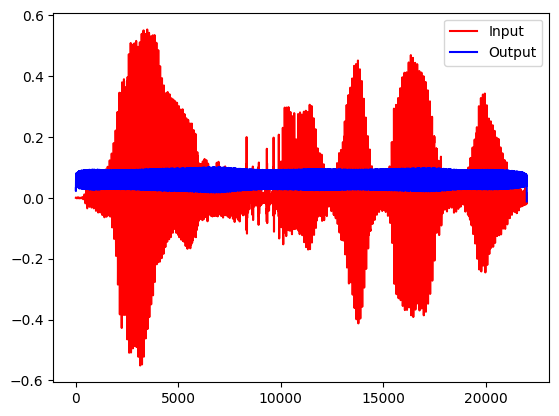

In [ ]:
%matplotlib inline
import datetime
import os
from pathlib import Path

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from IPython.display import clear_output, display
from tensorboardX import SummaryWriter

dataset_path = "./dataset/mels"
os.makedirs("./checkpoints", exist_ok=True)
mel_file_paths = os.listdir(dataset_path)
files = list(Path("./LJSpeech-1.1").rglob("*.wav"))


def truncate_and_pad_mel(audio: jax.Array, width: int = 86):
    """This corresponds to around 2 seconds of audio, based on hop length, audio sample rate and window size.

    Args:
        audio (jax.Array): _description_
        width (int, optional): _description_. Defaults to 86.

    Returns:
        _type_: _description_
    """
    audio_length = audio.shape[1]

    target_length = int(width)
    if audio_length > target_length:
        audio = audio[:, :target_length]
    else:
        audio = jnp.pad(audio, ((0, 0), (0, max(0, target_length - audio_length))))
    return audio


def truncate_and_pad_wav(audio, width: int = 22016):
    """This corresponds to around 2 seconds of audio, based on hop length, audio sample rate and window size.

    Args:
        audio (jax.Array): _description_
        width (int, optional): _description_. Defaults to 86.

    Returns:
        _type_: _description_
    """
    audio_length = audio.shape[0]

    target_length = int(width)
    if audio_length > target_length:
        audio = audio[:target_length]
    else:
        audio = jnp.pad(audio, ((0, max(0, target_length - audio_length))))
    return audio


def get_batch(idx: list):
    batch_mel = []
    batch_wav = []

    for id in idx:
        array = jnp.load(os.path.join(dataset_path, mel_file_paths[id]))[0]
        padded = truncate_and_pad_mel(array)
        batch_mel.append(padded)

        array, _ = librosa.load(files[id])
        padded_array = truncate_and_pad_wav(array)
        padded_array = jnp.expand_dims(padded_array, 0)
        batch_wav.append(padded_array)  # 2 Seconds

    return jnp.array(batch_mel), jnp.array(batch_wav)


key = jax.random.PRNGKey(69)

key1, key2, key3 = jax.random.split(key, 3)

generator = Generator(channels_in=80, channels_out=1, key=key1)
eqx.tree_deserialise_leaves("checkpoints/13.eqx", generator)

scale_disc = MultiScaleDiscriminator(key=key2)
period_disc = MultiPeriodDiscriminator(key=key3)

optim1 = optax.adam(2e-4, b1=0.8, b2=0.99)

# Assuming 'generator' is your input
gan_optim = optim1.init(generator)  # type: ignore

optim2 = optax.adam(1e-4)
scale_optim = optim2.init(scale_disc)  # type: ignore

optim3 = optax.adam(1e-4)
period_optim = optim3.init(period_disc)  # type: ignore

writer = SummaryWriter(
    log_dir="./runs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
)

epochs = 100
batch_size = 32
fig, ax = plt.subplots(1)
fig.show()

for epoch in range(epochs):
    key, grab = jax.random.split(key, 2)
    perm = jax.random.permutation(grab, len(mel_file_paths))
    eqx.tree_serialise_leaves(f"checkpoints/{epoch}.eqx", generator)

    for i in range(0, len(mel_file_paths), batch_size):
        batch_indices = perm[i : i + batch_size]
        mels, wavs = get_batch(batch_indices)

        # Terrifying
        (
            gan_loss,
            period_loss,
            scale_loss,
            generator,
            period_disc,
            scale_disc,
            gan_optim,
            period_optim,
            scale_optim,
            output,
        ) = make_step(
            generator,
            period_disc,
            scale_disc,
            mels,
            wavs,
            gan_optim,
            period_optim,
            scale_optim,
            optim1,
            optim2,
            optim3,
        )

        step = epoch * len(mel_file_paths) + i
        # Log codebook updates to TensorBoard
        writer.add_scalar("Loss/Generator", gan_loss, step)
        writer.add_scalar("Loss/Multi Period", period_loss, step)
        writer.add_scalar("Loss/Multi Scale", scale_loss, step)

        if (i // batch_size) % 20 == 0:
            ax.clear()
            ax.plot(wavs[0, 0], color="red", label="Input")
            ax.plot(output[0, 0], color="blue", label="Output")
            ax.legend()  # Add legend before displaying the figure
            display(fig)

            clear_output(wait=True)
    # plt.imshow(y[0])


I haven't gotten around to training the model from A to Z but we can see that the initial iterations are quite chaotic. 

![Results after 1 iteration](assets/cooking.png)

---
nocite: |
  @*
---

# References